In [ ]:
# ------------------------------mount drive-------------------------------------
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Colab\ Notebooks/nonlinear-sys-id/simple\ pendulum\ neurips/
# !ls

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/nonlinear-sys-id/simple pendulum neurips


In [ ]:
import numpy as np
from scipy.stats import truncnorm
import random
import matplotlib.pyplot as plt
import math

g = 9.81  # (m/s^2)  gravity constant
dt = 0.01  # time_step for discrete-time system

def system_parameters():
    m = 0.1  # (kg)    mass
    l = 0.5  # (m) distance between the rotor and the center of mass
    k = 2  # controller gain
    return m, l, k

def generate_u(input_, time_hor, s_, mean, std, u_max, lb, ub):  # noise in control input
    if input_ == "trunc_guass":
        np.random.seed(s_)
        rv = truncnorm(-u_max, u_max, loc=mean, scale=std)
        r1 = rv.rvs(size=time_hor)
        return r1
    elif input_ == "uniform":
        np.random.seed(s_)
        r1 = np.random.uniform(low=lb, high=ub, size=time_hor)
        return r1
    elif input_ == "bernouli":
        np.random.seed(s_)
        r0 = np.random.rand(time_hor)
        r1 = []
        for k in range(len(r0)):
          if r0[k] < 0.5:
            r1.append(0.5)
          else:
            r1.append(-0.5)
        return r1

def generate_w(distr, time_hor, s_, mean, std, w_max, lb, ub):  # disturbance
    if distr == "trunc_guass":
        np.random.seed(s_)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r1 = rv.rvs(size=time_hor)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r2 = rv.rvs(size=time_hor)
        return r1, r2
    elif distr == "uniform":
        np.random.seed(s_)
        r1 = np.random.uniform(low=lb, high=ub, size=time_hor)
        r2 = np.random.uniform(low=lb, high=ub, size=time_hor)
        return r1, r2
    elif distr == "bernouli":
        np.random.seed(s_)
        r01 = np.random.rand(time_hor)
        r02 = np.random.rand(time_hor)
        r1 = []
        r2 = []
        for k in range(len(r01)):
          if r01[k] < 0.5:
            r1.append(100)
          else:
            r1.append(-100)
        for k in range(len(r02)):
          if r02[k] < 0.5:
            r2.append(100)
          else:
            r2.append(-100)
        return r1, r2

class SimplePendulumDynamics:
    def __init__(self, distr, input):
        self.state = None
        self.u0 = None
        self.distr = distr
        self.input = input
        self.m, self.l, self.k = system_parameters()
        self.alpha_list = []
        self.omega_list = []
        self.phi_s_u_list = []
        self.b_s_list = []
        self.phi_list = []
        self.state_list = []

    def plot_trajectory(self):
        t_list = np.array(range(len(self.alpha_list))) * dt
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.4)   # wspace: space between subplots in a row

        # print(np.sin(np.array(self.alpha_list)))
        axs[0].plot(t_list, np.sin(np.array(self.alpha_list)), label='$sin(\\alpha)$')
        axs[0].plot(t_list, np.array(self.alpha_list), label='$\\alpha$')
        # axs[0].scatter(t_list, np.sin(np.array(self.alpha_list)), marker='o')
        # plt.title("Quadrotor's Position")
        axs[0].set_xlabel('time (s)')
        axs[0].set_ylabel('$\\alpha$ ($rad$)')
        axs[0].legend()

        # print(np.array(self.omega_list))
        axs[1].plot(t_list, self.omega_list, label='$\omega$')
        # axs[1].scatter(t_list, self.omega_list, marker='o')
        # plt.title("Quadrotor's Angular Velocity")
        axs[1].set_xlabel('time (s)')
        axs[1].set_ylabel('$\omega$ ($rad/s^{2}$)')
        axs[1].legend()

        plt.show()

    def update_feature_list(self, phi_s_u, s_, s, ex):
        self.phi_s_u_list.append(phi_s_u)
        self.b_s_list.append(s - s_ - ex)

    def update_feat(self, y):
        self.phi_list.append(y)


    def get_trajectory_3(self, x0, time_hor, s_u, s_w, param_u, mult_u, param_w, mult_w):

        # ----------------------------------------- initial states -----------------------------------------------------
        self.state = x0
        x = np.array(x0)
        alpha_ = x[0]  # angle
        omega_ = x[1]  # angular velocity

        #  ------------------------------------- Storing the states - ---------------------------------------------
        self.alpha_list = [alpha_]
        self.omega_list = [omega_]
        self.state_list = [np.array([alpha_, omega_])]

        if self.input == "trunc_guass":
          u_max_ = param_u[2]
        else:
          u_max_ = 1.0

        if self.distr == "trunc_guass":
          w_max_ = param_w[2]
        else:
          w_max_ = 1.0

        # -----------------  random noise and disturbance generation ---------------------------------------------------
        U1_list = generate_u(self.input, time_hor, s_u, mean=param_u[0], std=param_u[1], u_max=u_max_, lb=param_u[0], ub=param_u[1])
        W1_list, W2_list = generate_w(self.distr, time_hor, s_w, mean=param_w[0], std=param_w[1], w_max=w_max_, lb=param_w[0], ub=param_w[1])

        for t in range(time_hor):

            s_ = omega_

            # ------------------  noise in control input  (for exploration)  ----------------------------------------
            u1 = U1_list[t]

            # ----------------   noise in control input  (for exploration)  -----------------------------------------
            w1 = mult_w[0] * W1_list[t]
            w2 = mult_w[1] * W2_list[t]

            # ----------------------------------------  PD control + noise  ------------------------------------------
            u = - self.k * omega_ + u1

            # ------------------------------------------  Dynamic model ----------------------------------------------
            alpha_dot = omega_ + w1
            omega_dot = - g * math.sin(alpha_) / self.l + u / (self.m * self.l * self.l) + w2

            phi_s_u = np.array([-g*math.sin(alpha_), u])
            self.update_feat(phi_s_u)

            # -------------------------------------- Updating the states --------------------------------------------
            alpha = alpha_ + dt * alpha_dot
            omega = omega_ + dt * omega_dot

            self.state = np.array([alpha, omega])

            s = omega

            self.update_feature_list(dt * phi_s_u, s_, s, 0)

            omega_ = omega
            alpha_ = alpha

            # ------------------------------------- Storing the states ----------------------------------------------
            self.alpha_list.append(alpha)
            self.omega_list.append(omega)
            self.state_list.append(np.array([alpha, omega]))


In [ ]:
# --------------------------import packages-------------------------------------
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from scipy.stats import norm
np.set_printoptions(threshold=np.inf)

# ----------------------import classes and functions----------------------------
# from pendulum_dynamics import SimplePendulumDynamics

# --------------------------ground_truth parameters-----------------------------
m, l, _ = system_parameters()
ground_truth = [1 / l, 1 / m / l / l]
print("-----------------------------------------------------------------------")
print("ground truth = ", ground_truth)
print("-----------------------------------------------------------------------")

n_epoch = 20             # number trajectories
max_time_hor = 200002      # maximum trajectory length

# ------------------------------disturbacne-------------------------------------
disturbance: str = "trunc_guass"
parameter_dist = [0.0, 0.1, 10]  # mean and std

# disturbance: str = "bernouli"

# disturbance: str = "uniform"
# parameter_dist = [-1, 1]  # lb and ub

mult_w = [1, 1]
seeds_w = range(300, 500) # fixing seeds
w_max = 1             # maximum disturbance (required to run set membership)

# ---------------------------------noise----------------------------------------
c_input: str = "trunc_guass"
parameter_input = [0.0, 1, 1]  # mean and std and scale

# c_input: str = "bernouli"

# c_input: str = "uniform"
# parameter_input = [-1, 1]  # lb and ub

mult_u = [1]
seeds_u = range(100, 300)   # fixing seeds


print('------------------Getting Trajectory Data of Quadrotor-----------------')
# theta_hat_list = []
Delta_S_list = []
Phi_S_U_list = []
Phi_list = []
State_list = []

for e in range(n_epoch):
  x0 = [0.0 , 0.0]
  pend = SimplePendulumDynamics(c_input, disturbance)
  pend.get_trajectory_3(x0, max_time_hor, seeds_u[e], seeds_w[e], parameter_input, mult_u, parameter_dist, mult_w)
  # print("---------------------------------------------------------------------")
  print("e = ", e + 1)
  # pend.plot_trajectory()

  Delta_S_list.append(pend.b_s_list)
  Phi_S_U_list.append(pend.phi_s_u_list)     # nonlinear feature vector

  Phi_list.append(pend.phi_list)
  State_list.append(pend.state_list)

print('-------------------------------Data Saved------------------------------')

-----------------------------------------------------------------------
ground truth =  [2.0, 40.0]
-----------------------------------------------------------------------
------------------Getting Trajectory Data of Quadrotor-----------------
e =  1
e =  2
e =  3
e =  4
e =  5
e =  6
e =  7
e =  8
e =  9
e =  10
e =  11
e =  12
e =  13
e =  14
e =  15
e =  16
e =  17
e =  18
e =  19
e =  20
-------------------------------Data Saved------------------------------


# Run LSE

In [ ]:
from scipy.spatial import HalfspaceIntersection
from scipy.optimize import linprog
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt


# -------------------------- Pendulum --------------------------
m = 0.1  # (kg)    mass
l = 0.5  # (m) rod length
theta_star = np.array([1 / l, 1 / (m * l * l)])

def run_lst(S, Phi_S_U):

    Y: object = []
    X: object = []

    for t in range(len(Phi_S_U)):

        delta_S = S[t]
        phi_s_u = Phi_S_U[t]

        Y.append([delta_S])
        X.append([phi_s_u[0], phi_s_u[1]])


    YY = np.array(Y)
    XX = np.array(X)

    theta_hat = (sc.linalg.pinv(XX) @ YY).T
    theta_hat_ = np.array([theta_hat[0,0], theta_hat[0,1]])
    return theta_hat_


In [ ]:
import numpy as np
# from lse_pend import run_lst

# time_hor_ = [1, 500]
# time_hor_.extend(range(1000, 10000, 1000))
# time_hor_.extend(range(10000, 100000, 10000))
# time_hor_.extend([100000])

time_hor_ = [1, 500]
time_hor_.extend(range(1000, 10000, 1000))
time_hor_.extend(range(10000, 200000, 10000))
time_hor_.extend([200000])


print('-------------------------------Run LSE---------------------------------')

mean_delta_theta_hat_list = []
std_delta_theta_hat_list = []

for k in range(len(time_hor_)):

    print('T = ' + str(time_hor_[k]))
    delta_theta_hat_list_ = []

    for e in range(n_epoch):
        theta_hat = run_lst(Delta_S_list[e][:time_hor_[k]], Phi_S_U_list[e][:time_hor_[k]])
        delta_theta_hat_list_.append(abs(theta_hat - np.array(ground_truth)))

    mean_delta_theta_hat_list.append(np.mean(np.array(delta_theta_hat_list_), axis=0))
    alpha = 0.05  # 95% confidence interval
    z_score = norm.ppf(1 - alpha / 2)
    coeff = z_score / np.sqrt(n_epoch)
    coeff = 1
    std_delta_theta_hat_list.append(coeff * np.std(np.array(delta_theta_hat_list_), axis=0))

# save array into csv file
name1 = 'lse_data5_' + 'w_' + disturbance + '_' + str(parameter_dist) + '_' + str(mult_w) + '_u_' + c_input + '_' + str(parameter_input) + '_' + str(mult_u) + '.csv'
name2 = 'lse_data6_' + 'w_' + disturbance + '_' + str(parameter_dist) + '_' + str(mult_w) + '_u_' + c_input + '_' + str(parameter_input) + '_' + str(mult_u) + '.csv'
np.savetxt(name1, np.array(mean_delta_theta_hat_list), delimiter = ",")
np.savetxt(name2, np.array(std_delta_theta_hat_list), delimiter = ",")

print('-------------------------------Data Saved------------------------------')

-------------------------------Run LSE---------------------------------
T = 1
T = 500
T = 1000
T = 2000
T = 3000
T = 4000
T = 5000
T = 6000
T = 7000
T = 8000
T = 9000
T = 10000
T = 20000
T = 30000
T = 40000
T = 50000
T = 60000
T = 70000
T = 80000
T = 90000
T = 100000
T = 110000
T = 120000
T = 130000
T = 140000
T = 150000
T = 160000
T = 170000
T = 180000
T = 190000
T = 200000
-------------------------------Data Saved------------------------------


In [ ]:
s_phi = 0.0005
p_phi = 0.7
b_phi = 1e-6
w_max = 0.01

m = 1
n_x = 1
n_phi = 2
# sigma_w = np.sqrt((2*w_max)**2/12)
sigma_w = parameter_dist[1]*0.01
delta = 0.05

time_hor = 100002
theo_bound = []
time_list = []
for k in range(time_hor):
  cc = b_phi/delta/s_phi/s_phi
  cond = (10/p_phi) * (np.log(1/delta) + 2*n_phi*np.log(10/p_phi) + n_phi*np.log(cc))
  if (k+1) >= cond:
    time_list.append(k+1)
    theo_bound_ = (90*sigma_w/p_phi) * np.sqrt((n_x + np.log(1/delta) + n_phi*np.log(10/p_phi) + n_phi*np.log(cc)) / ((k+1)*s_phi))
    theo_bound.append(theo_bound_)

# print(time_list)
# print(theo_bound)
# print(np.linalg.norm(np.array(ground_truth)))

disturbance = 'uniform'
mult_w = [1, 1]
name1 = 'lse_theo_bound_1_' + 'w_' + disturbance + '_' + str(sigma_w) + '_' + 's_phi' '_' + str(s_phi) + '_' + 'p_phi' +  '_' + str(p_phi) +  '_' + 'delta' +   '_' + str(delta) + '.csv'
name2 = 'lse_theo_bound_2_' + 'w_' + disturbance + '_' + str(sigma_w) + '_' + 's_phi' '_' + str(s_phi) + '_' + 'p_phi' +  '_' + str(p_phi) +  '_' + 'delta' +   '_' + str(delta) + '.csv'
np.savetxt(name1, np.array(time_list), delimiter = ",")
np.savetxt(name2, np.array(theo_bound), delimiter = ",")

------------------------LSE Estimation Error Plots---------------------


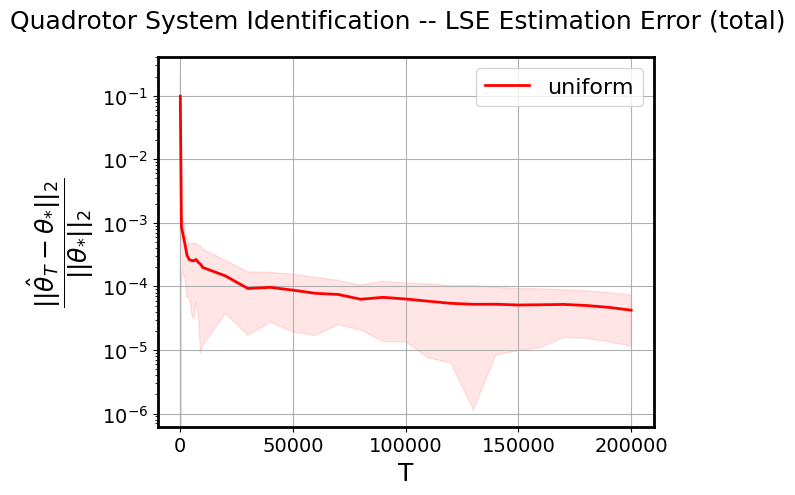

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True

linewidth_ = 2.0
alpha_ = 0.1

log_scale = True
separate = False   # True means plot the individual error and total error in the same figure
normalize = True   # True means normalize the individual error when plotting

def plot_lse(mean_theta_hat_list, std_theta_hat_list, ground_truth, time_hor):

  time_hor_ = np.array(time_hor)

  points = []
  errors = []
  c0 = 1
  if normalize:
    c0 = np.linalg.norm(ground_truth)
  for j in range(len(mean_theta_hat_list)):
    points.append(np.linalg.norm(mean_theta_hat_list[j]) / c0)
    errors.append(np.linalg.norm(std_theta_hat_list[j]) / c0)

  fig = plt.figure()
  plt.plot(time_hor_, points, color='red', label=disturbance, linewidth=linewidth_)
  plt.fill_between(time_hor_, np.array(points) - np.array(errors), np.array(points) + np.array(errors), color='red', alpha=alpha_)
  # plt.xticks([1, 5000, 10000])
  plt.xlabel('T')
  if normalize:
    plt.ylabel('$\\dfrac{||\hat{\\theta}_{T} - \\theta_{*}||_{2}}{||\\theta_{*}||_{2}}$')
  else:
    plt.ylabel('$||\hat{\\theta}_{T} - \\theta_{*}||_{2}$')
  plt.legend()
  fig.suptitle('Quadrotor System Identification -- LSE Estimation Error (total)')
  if log_scale:
    plt.yscale('log')

  plt.show()

print('------------------------LSE Estimation Error Plots---------------------')
plot_lse(mean_delta_theta_hat_list, std_delta_theta_hat_list, ground_truth, time_hor_)


In [ ]:
m, l, _ = system_parameters()
ground_truth = [1 / l, 1 / m / l / l]
time_hor_ = [1, 500]
time_hor_.extend(range(1000, 10000, 1000))
time_hor_.extend(range(10000, 100000, 10000))
time_hor_.extend([100000])

In [ ]:
# --------------------------ground_truth parameters-----------------------------
m, l, _ = system_parameters()
ground_truth = [1 / l, 1 / m / l / l]
print("-----------------------------------------------------------------------")
print("ground truth = ", ground_truth)
print("-----------------------------------------------------------------------")

-----------------------------------------------------------------------
ground truth =  [2.0, 40.0]
-----------------------------------------------------------------------


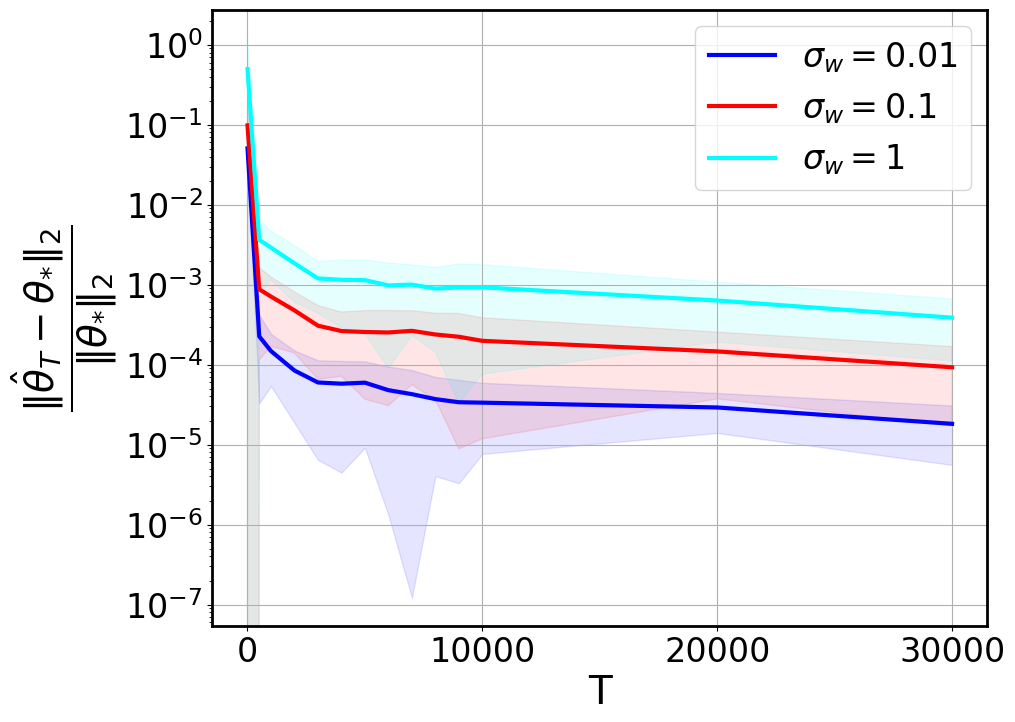

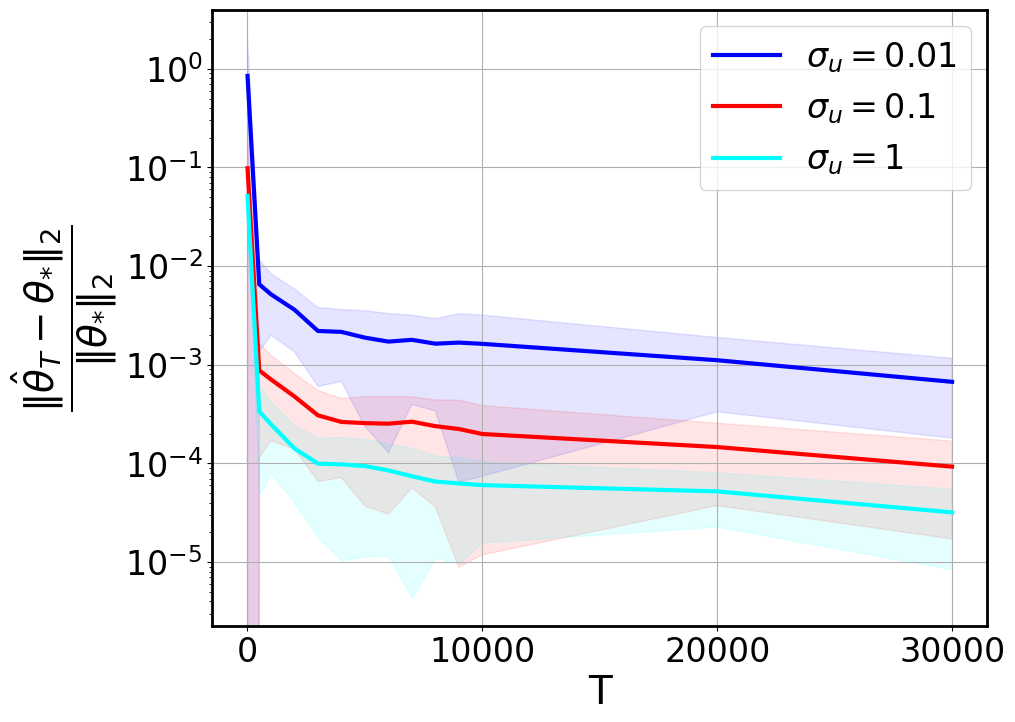

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2

normalize = True
log_scale_x = False
log_scale_y = True

if normalize:
  c_norm = np.linalg.norm(np.array(ground_truth))
else:
  c_norm = 1


colors = ['blue', 'red', 'cyan', 'cyan', 'pink', 'red', 'magenta', 'orange', 'green']

linewidth_ = 3.0
alpha_ = 0.1

time_hor_ = [1, 500]
time_hor_.extend(range(1000, 10000, 1000))
time_hor_.extend(range(10000, 200000, 10000))
time_hor_.extend([200000])

# --------------------------------------------------Truncated Gaussian----------------------------------------------------------------------
# -----------------------------------------------------u fixed, w changing------------------------------------------------------------------
fig = plt.figure(figsize=(10, 8))

name1 = 'lse_data3_w_trunc_guass_[0.0, 0.01, 100]_[1, 1]_u_trunc_guass_[0.0, 0.1, 10]_[1].csv'
name2 = 'lse_data4_w_trunc_guass_[0.0, 0.01, 100]_[1, 1]_u_trunc_guass_[0.0, 0.1, 10]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = '$\sigma_{w}=0.01$'
ind1 = 0
ind2 = 14
plt.plot(time_list[ind1:ind2], points[ind1:ind2], color=colors[0], label=label1, linewidth=linewidth_)
# plt.scatter(time_list[ind:], points[ind:], color=colors[0], marker='o')
plt.fill_between(time_list[ind1:ind2], np.array(points[ind1:ind2]) - np.array(errors[ind1:ind2]), np.array(points[ind1:ind2]) + np.array(errors[ind1:ind2]), color=colors[0], alpha=alpha_)


name1 = 'lse_data3_w_trunc_guass_[0.0, 0.1, 10]_[1, 1]_u_trunc_guass_[0.0, 0.1, 10]_[1].csv'
name2 = 'lse_data4_w_trunc_guass_[0.0, 0.1, 10]_[1, 1]_u_trunc_guass_[0.0, 0.1, 10]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = '$\sigma_{w}=0.1$'
plt.plot(time_list[ind1:ind2], points[ind1:ind2], color=colors[1], label=label1, linewidth=linewidth_)
# plt.scatter(time_list[ind:], points[ind:], color=colors[0], marker='o')
plt.fill_between(time_list[ind1:ind2], np.array(points[ind1:ind2]) - np.array(errors[ind1:ind2]), np.array(points[ind1:ind2]) + np.array(errors[ind1:ind2]), color=colors[1], alpha=alpha_)

name1 = 'lse_data3_w_trunc_guass_[0.0, 1, 1]_[1, 1]_u_trunc_guass_[0.0, 0.1, 10]_[1].csv'
name2 = 'lse_data4_w_trunc_guass_[0.0, 1, 1]_[1, 1]_u_trunc_guass_[0.0, 0.1, 10]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = '$\sigma_{w}=1$'
plt.plot(time_list[ind1:ind2], points[ind1:ind2], color=colors[2], label=label1, linewidth=linewidth_)
# plt.scatter(time_list[ind:], points[ind:], color=colors[0], marker='o')
plt.fill_between(time_list[ind1:ind2], np.array(points[ind1:ind2]) - np.array(errors[ind1:ind2]), np.array(points[ind1:ind2]) + np.array(errors[ind1:ind2]), color=colors[2], alpha=alpha_)

plt.xticks([0, 10000, 20000, 30000])
# plt.xlim([None, 1e5+1])
if log_scale_x:
  plt.xscale('log')
if log_scale_y:
  plt.yscale('log')

plt.xlabel('T')
if normalize:
  plt.ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
else:
 plt.ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')

plt.legend()


# # --------------------------------------------------Truncated Gaussian----------------------------------------------------------------------
# # -----------------------------------------------------w fixed, u changing------------------------------------------------------------------
fig = plt.figure(figsize=(10, 8))

name1 = 'lse_data5_w_trunc_guass_[0.0, 0.1, 10]_[1, 1]_u_trunc_guass_[0.0, 0.01, 100]_[1].csv'
name2 = 'lse_data6_w_trunc_guass_[0.0, 0.1, 10]_[1, 1]_u_trunc_guass_[0.0, 0.01, 100]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = '$\sigma_{u}=0.01$'
plt.plot(time_list[ind1:ind2], points[ind1:ind2], color=colors[0], label=label1, linewidth=linewidth_)
# plt.scatter(time_list[ind:], points[ind:], color=colors[0], marker='o')
plt.fill_between(time_list[ind1:ind2], np.array(points[ind1:ind2]) - np.array(errors[ind1:ind2]), np.array(points[ind1:ind2]) + np.array(errors[ind1:ind2]), color=colors[0], alpha=alpha_)


name1 = 'lse_data5_w_trunc_guass_[0.0, 0.1, 10]_[1, 1]_u_trunc_guass_[0.0, 0.1, 10]_[1].csv'
name2 = 'lse_data6_w_trunc_guass_[0.0, 0.1, 10]_[1, 1]_u_trunc_guass_[0.0, 0.1, 10]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = '$\sigma_{u}=0.1$'
plt.plot(time_list[ind1:ind2], points[ind1:ind2], color=colors[1], label=label1, linewidth=linewidth_)
# plt.scatter(time_list[ind:], points[ind:], color=colors[0], marker='o')
plt.fill_between(time_list[ind1:ind2], np.array(points[ind1:ind2]) - np.array(errors[ind1:ind2]), np.array(points[ind1:ind2]) + np.array(errors[ind1:ind2]), color=colors[1], alpha=alpha_)


name1 = 'lse_data5_w_trunc_guass_[0.0, 0.1, 10]_[1, 1]_u_trunc_guass_[0.0, 1, 1]_[1].csv'
name2 = 'lse_data6_w_trunc_guass_[0.0, 0.1, 10]_[1, 1]_u_trunc_guass_[0.0, 1, 1]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = '$\sigma_{u}=1$'
plt.plot(time_list[ind1:ind2], points[ind1:ind2], color=colors[2], label=label1, linewidth=linewidth_)
# plt.scatter(time_list[ind:], points[ind:], color=colors[0], marker='o')
plt.fill_between(time_list[ind1:ind2], np.array(points[ind1:ind2]) - np.array(errors[ind1:ind2]), np.array(points[ind1:ind2]) + np.array(errors[ind1:ind2]), color=colors[2], alpha=alpha_)


# plt.xlim([None, 3e4+1])
plt.xticks([0, 10000, 20000, 30000])
if log_scale_x:
  plt.xscale('log')
if log_scale_y:
  plt.yscale('log')

plt.xlabel('T')
if normalize:
  plt.ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
else:
 plt.ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')

plt.legend()


plt.show()